# AICE Professional

1. Tabular 데이터 Brain stroke prediction dataset
- 데이터 출처 : https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
2. Text 데이터 Twitter Sentiment
- 데이터 출처 : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
3. Img 데이터 Flower_Classification_5class
- 데이터 출처 : https://www.kaggle.com/datasets/sauravagarwal/flower-classification

# AICE Professional-3 Image 분류 모델 만들기

In [ ]:

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

!unzip cats_and_dogs_filtered.zip

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
!ls ./

cats_and_dogs_filtered	cats_and_dogs_filtered.zip  sample_data


In [ ]:
!pwd

/content


In [ ]:
input_shape=(224,224,3)
num_classes=2

In [ ]:
img_path = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(img_path, 'train')
validation_dir = os.path.join(img_path, 'validation')

In [ ]:
batch_size=32
image_size=(224,224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=image_size,
    seed=42,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = validation_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=image_size,
    seed=42,
    shuffle=False
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


/tmp/ipython-input-8-721577097.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


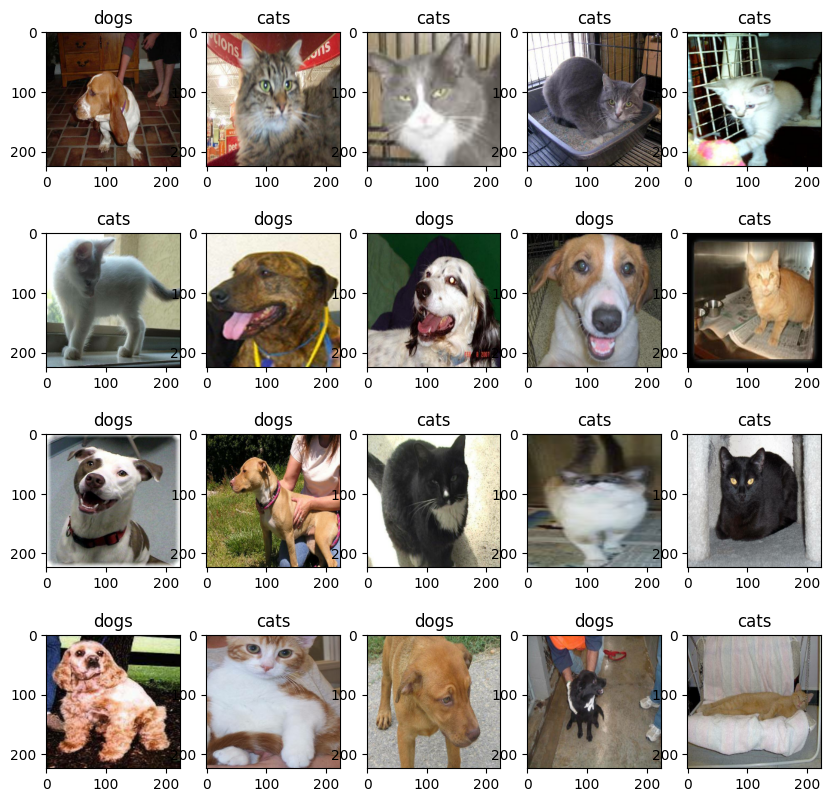

In [ ]:
plt.figure(figsize=(10,10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_idx = int(labels[i].numpy())
    plt.title(class_names[label_idx])
    plt.axis=("off")


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(
    monitor='var_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True,
    mode='min'
)

mc = ModelCheckpoint(
    filepath='my_checkpoint.keras',
    monitor='val_loss',    ## loss 기준
   #monitor='val_accuracy' ## 정확도 기준
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[es, mc],
    verbose=1 ## 학습 과정 출력
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6598 - loss: 0.6173
Epoch 1: val_loss improved from -inf to 0.22855, saving model to my_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `var_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - accuracy: 0.6619 - loss: 0.6150 - val_accuracy: 0.9700 - val_loss: 0.2286
Epoch 2/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9567 - loss: 0.2202
Epoch 2: val_loss did not improve from 0.22855
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9569 - loss: 0.2195 - val_accuracy: 0.9830 - val_loss: 0.1280
Epoch 3/20
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9758 - loss: 0.1357
Epoch 3: val_loss did not improve from 0.22855
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9758 - loss: 0.1354 - val_accuracy: 0.9870 - val_loss: 0.0936
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9819 - loss: 0.1014
Epoch 4: val_loss did not improve from 0.22855
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9819 - loss: 0.1014 - val_accuracy: 0.9860 - val_loss: 0.0756
Epoch 5/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9817 - loss: 0.0800
Epoch 5: val_loss did not improve from 0.22855
63/63 

In [ ]:
model.load_weights('my_checkpoint.keras')

In [ ]:
##model.save('best_model.h5') ## HDF5 형식
model.save('best_model.keras') ## keras 형식

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [ ]:
# 검증 데이터에서 한 배치 가져오기
batch_img, batch_label = next(iter(test_ds))

In [ ]:
batch_img.shape, batch_label.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 1]))

In [ ]:
predictions = model.predict(batch_img, verbose=0)
predicted_classes = (predictions > 0.5).astype(int).flatten()

In [ ]:
## TO-BE 방식
i=1
plt.figure(figsize=(16,30))
for img, label in list(zip(batch_img, batch_label)):
  pred = model.predict(img.numpy().reshape(-1,224,224,3), verbose=0)
  # pred는 [[확률]] 형태이므로 첫 번째 (유일한) 확률 값을 가져옵니다.
  predicted_probability = pred[0][0] # pred가 [[0.1234]] 형태일 때 0.1234 값을 가져옴
  # 임계값 0.5를 기준으로 클래스 결정 (이진 분류)
  pred_t = 1 if predicted_probability > 0.5 else 0

  true_t = int(label.numpy()[0])
  plt.subplot(8,4,i)
  plt.title(f"True Value:{true_t}, Pred Valud: {pred_t}")
  plt.imshow(img/255)
  i=i+1

In [ ]:
correct_predictions = np.sum(predicted_classes == batch_label.numpy())
batch_accuracy = correct_predictions / len(batch_label)
print(f"📊 배치 정확도: {batch_accuracy:.4f} ({correct_predictions}/{len(batch_label)})")

📊 배치 정확도: 32.0000 (1024/32)


In [ ]:
## AS-IS 방식
i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

In [ ]:
correct_predictions = np.sum(predicted_classes == batch_label.numpy())
batch_accuracy = correct_predictions / len(batch_label)
print(f"📊 배치 정확도: {batch_accuracy:.4f} ({correct_predictions}/{len(batch_label)})")

In [ ]:
from keras.preprocessing import image

In [ ]:
## TO-BE 방식
def predict_images_in_directory_binary(model, img_path, class_names, batch_size=32, threshold=0.5):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    # Rescaling 레이어는 모델 내부에 있으므로 여기서는 추가 전처리 불필요 (load_img, img_to_array만 사용)
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 리사이즈
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224) # 모델 입력 크기와 일치
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            # MobileNetV2 입력 스케일링 (1./127.5, offset=-1)은 모델 내부에 Rescaling 레이어로 처리되므로
            # 여기서는 추가적으로 수동 스케일링할 필요가 없습니다.

            image_files.append(filename)
            image_arrays.append(img_array)

    if not image_arrays:
        print(f"경로 {img_path}에서 유효한 이미지를 찾을 수 없습니다.")
        return []

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    # 이진 분류 모델의 predict 결과는 (배치_크기, 1) 형태의 확률 값입니다.
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)

    # 예측된 확률을 기반으로 클래스 결정
    # predictions는 (num_images, 1) 형태이므로 [:, 0]으로 첫 번째 (유일한) 차원을 가져옴
    predicted_classes = []
    for prob in predictions[:, 0]: # 각 이미지에 대한 단일 확률 값
        if prob > threshold:
            predicted_classes.append(class_names[1]) # 긍정 클래스 (예: dog)
        else:
            predicted_classes.append(class_names[0]) # 부정 클래스 (예: cat)

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
# 가상의 이진 분류 모델과 클래스 이름을 가정합니다.
# 실제 모델은 dogs vs cats와 같은 이진 분류를 위해 sigmoid 활성화 함수를 사용해야 합니다.

# 예시: train_ds가 이진 분류용으로 생성된 경우
# 예를 들어, train_ds.class_names가 ['cat', 'dog']와 같이 2개 클래스를 가진다고 가정
# class_names_for_binary = train_ds.class_names
# 혹은 직접 정의
class_names_for_binary = ['cat', 'dog'] # 예시: 0이 'cat', 1이 'dog'을 의미한다고 가정

# 'validation_dir'이라는 변수가 정의되어 있다고 가정
# test_dir 경로도 이진 분류의 단일 클래스 폴더가 아닌,
# 예측하고자 하는 이미지들이 직접 들어있는 폴더여야 합니다.
# (예: test_images/test_dog.jpg, test_images/test_cat.jpg)
# 임시 테스트 디렉토리 생성 (실제 사용 시에는 존재하는 경로로 변경)
#temp_test_images_dir = '/content/cats_and_dogs_filtered/validation/cats/'
temp_test_images_dir = '/content/cats_and_dogs_filtered/validation/dogs/'

# 이제 함수 호출
results_binary = predict_images_in_directory_binary(model, temp_test_images_dir, class_names=class_names_for_binary)

# 결과 출력
if results_binary:
    print("\n----- 예측 결과 (이진 분류) -----")
    for filename, predicted_type in results_binary[:20]: # 처음 20개만
        print(f"파일명: {filename}, 예측된 종류: {predicted_type}")
    print(f"\n총 예측된 이미지 수: {len(results_binary)}")
else:
    print("예측할 이미지를 찾을 수 없거나 예측 결과가 없습니다.")

클래스 매핑: {0: 'cats', 1: 'dogs'}
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step

----- 예측 결과 (이진 분류) -----
파일명: dog.2490.jpg, 예측된 종류: cats
파일명: dog.2196.jpg, 예측된 종류: dogs
파일명: dog.2345.jpg, 예측된 종류: dogs
파일명: dog.2081.jpg, 예측된 종류: dogs
파일명: dog.2000.jpg, 예측된 종류: dogs
파일명: dog.2227.jpg, 예측된 종류: dogs
파일명: dog.2183.jpg, 예측된 종류: cats
파일명: dog.2443.jpg, 예측된 종류: dogs
파일명: dog.2287.jpg, 예측된 종류: dogs
파일명: dog.2481.jpg, 예측된 종류: dogs
파일명: dog.2236.jpg, 예측된 종류: dogs
파일명: dog.2334.jpg, 예측된 종류: dogs
파일명: dog.2457.jpg, 예측된 종류: dogs
파일명: dog.2028.jpg, 예측된 종류: dogs
파일명: dog.2242.jpg, 예측된 종류: dogs
파일명: dog.2356.jpg, 예측된 종류: dogs
파일명: dog.2393.jpg, 예측된 종류: dogs
파일명: dog.2087.jpg, 예측된 종류: dogs
파일명: dog.2126.jpg, 예측된 종류: dogs
파일명: dog.2293.jpg, 예측된 종류: dogs

총 예측된 이미지 수: 500


In [ ]:
## AS-IS 방식
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
test_dir = os.path.join(validation_dir, 'cats')
results = predict_images_in_directory(model, test_dir)
print(results.count(1))
# 결과 출력
for filename, type in results:
    print(f"파일명: {filename}, 종류: {type}")

In [ ]:

import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results_binary, columns=['filename', 'predicted_type'])

csv_filename = f'cat_and_docs_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측 종류별 개수:")
print(df['predicted_type'].value_counts())

결과가 cat_and_docs_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
       filename predicted_type
0  dog.2490.jpg           cats
1  dog.2196.jpg           dogs
2  dog.2345.jpg           dogs
3  dog.2081.jpg           dogs
4  dog.2000.jpg           dogs

예측 종류별 개수:
predicted_type
dogs    487
cats     13
Name: count, dtype: int64


## =====================================================================
## =====================================================================

In [ ]:
# github img 데이터셋 불러오기
!wget https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip

--2025-03-31 13:31:07--  https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip [following]
--2025-03-31 13:31:07--  https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229731827 (219M) [application/zip]
Saving to: ‘Flower_Classification_5class.zip’

Flower_Classificati 100%[===================>] 219.09M   264MB/s    in 0.8s    

2025-03-31 13:31:35 

In [ ]:
# Colab 환경에서 압축 파일 업로드했기에 사용한 부분입니다.
!unzip Flower_Classification_5class.zip -d /content/

In [ ]:
# 시험에서는 압축을 별도로 풀지 않고 train과 test 이미지 경로를 바로 사용할 수 있도록 경로를 제공해줍니다.
# 예시1 : /content/flowers/train/
# 예시2 : /content/flowers/valid/

# img flower_photos에 데이터셋 종류 확인
!ls -l /content/flowers/flowers/flower_photos

total 12
drwxr-xr-x 7 root root 4096 Mar 31 13:32 test
drwxr-xr-x 7 root root 4096 Mar 31 13:32 train
drwxr-xr-x 7 root root 4096 Mar 31 13:32 validation


In [ ]:
# img jpg, jpeg, png, gif 뭐가 있는지 확인
# 다른 데이터셋중에는 jpg, jpeg가 혼합되어 사용된 경우가 있었어서 확인하게 되었습니다.
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpeg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep png | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep gif | wc -l

607
0
0
0


In [ ]:
# img valid 데이터셋 폴더내 꽃 종류 확인
!ls -l /content/flowers/flowers/flower_photos/validation

total 20
drwxr-xr-x 2 root root 4096 Mar 31 13:32 daisy
drwxr-xr-x 2 root root 4096 Mar 31 13:32 dandelion
drwxr-xr-x 2 root root 4096 Mar 31 13:32 roses
drwxr-xr-x 2 root root 4096 Mar 31 13:32 sunflowers
drwxr-xr-x 2 root root 4096 Mar 31 13:32 tulips


In [ ]:
# img test 데이터셋 폴더내 daisy 갯수 및 이미지 풀네임 확인
!ls -l /content/flowers/flowers/flower_photos/test/daisy

total 396
-rw-r--r-- 1 root root 36410 Apr 18  2021 10172379554_b296050f82_n.jpg
-rw-r--r-- 1 root root 24463 Apr 18  2021 1306119996_ab8ae14d72_n.jpg
-rw-r--r-- 1 root root 31422 Apr 18  2021 134409839_71069a95d1_m.jpg
-rw-r--r-- 1 root root 24030 Apr 18  2021 19813618946_93818db7aa_m.jpg
-rw-r--r-- 1 root root 17466 Apr 18  2021 3338077096_3a8ed0e2bc_m.jpg
-rw-r--r-- 1 root root 15072 Apr 18  2021 3552074420_2a0a7166db_m.jpg
-rw-r--r-- 1 root root 70320 Apr 18  2021 4141147800_813f660b47.jpg
-rw-r--r-- 1 root root 43385 Apr 18  2021 538920244_59899a78f8_n.jpg
-rw-r--r-- 1 root root 40516 Apr 18  2021 5973488341_50bdf6cee3_n.jpg
-rw-r--r-- 1 root root 86338 Apr 18  2021 8446495985_f72d851482.jpg


In [ ]:
# img train, valid 경로 지정
train_img_path = '/content/flowers/flowers/flower_photos/train/'
valid_img_path = '/content/flowers/flowers/flower_photos/validation/'

In [ ]:
"""
지금은 train 데이터셋, valid 데이터셋이 제공되어서 train-train, valid-valid를 사용했습니다.
train 데이터셋 하나만 제공되는 경우에는 valid 데이터셋을 만들기 위해서는
directory, validation_split, subset을 아래처럼 수정해주시면 됩니다.

train
directory=train_img_path,
validation_split=0.2,
subset='training'

valid
directory=train_img_path,
validation_split=0.2,
subset='validation'

"""

# img train dataset 만들기
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='training'
)
# img valid dataset 만들기
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='validation'
)

Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.


In [ ]:
# img 사전학습 모델인 MobileNetV3Large 사용
# 이미지 사이즈는 사전 학습된 모델 호환성 – 많은 딥러닝 모델(VGG16, ResNet 등)이
# 224x224 크기의 이미지를 입력으로 사용하도록 학습되었기 때문에 이렇게 사용했습니다.
img_base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3), weights='imagenet', include_top=False)
img_base_model.trainable=False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# img dataset의 라벨 갯수 확인용 (5개)
train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# img 딥러닝 모델 제작
img_model = Sequential()
img_model.add(img_base_model)
img_model.add(Flatten())
img_model.add(Dense(256, activation=None))
img_model.add(BatchNormalization())
img_model.add(Activation('relu'))
img_model.add(Dropout(0.5))
img_model.add(Dense(5, activation='softmax'))

In [ ]:
#img 딥러닝 모델 compile
img_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# img 딥러닝 모델 훈련 fit
# img는 es3, mc3, history3 처럼 변수에 3을 붙여서 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc3 = ModelCheckpoint('best_img_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history3 = img_model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[es3, mc3],
    verbose=1
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7627 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.45077, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.7633 - loss: 0.6887 - val_accuracy: 0.8750 - val_loss: 0.4508
Epoch 2/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9672 - loss: 0.1219
Epoch 2: val_loss improved from 0.45077 to 0.32265, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9673 - loss: 0.1216 - val_accuracy: 0.9125 - val_loss: 0.3227
Epoch 3/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9937 - loss: 0.0397
Epoch 3: val_loss improved from 0.32265 to 0.30810, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9937 - loss: 0.0396 - val_accuracy: 0.9125 - val_loss: 0.3081
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9976 - loss: 0.0248
Epoch 4: val_loss did not imp

In [ ]:
# 시험에서는 csv 파일에 image 파일명이 제공되지만,
# 현재의 환경처럼 csv 파일이 없는 경우 시험 환경과 비슷하게 하기 위해 파일을 만드는 부분입니다.
# 시험에서는 이 부분은 사용하지 않으셔도 될겁니다.

img_glob = sorted(glob.glob('/content/flowers/flowers/flower_photos/test/*/*jpg'))
img_file = [os.path.basename(path) for path in img_glob]
img_label = [os.path.basename(os.path.dirname(path)) for path in img_glob]

# img Test 데이터셋을 이용해서 DataFrame 만들기
img_df5 = pd.DataFrame()
img_df5['image'] = img_glob
img_df5['file'] = img_file
img_df5['label'] = img_label
img_df5.head(10)

image  \
0  /content/flowers/flowers/flower_photos/test/da...   
1  /content/flowers/flowers/flower_photos/test/da...   
2  /content/flowers/flowers/flower_photos/test/da...   
3  /content/flowers/flowers/flower_photos/test/da...   
4  /content/flowers/flowers/flower_photos/test/da...   
5  /content/flowers/flowers/flower_photos/test/da...   
6  /content/flowers/flowers/flower_photos/test/da...   
7  /content/flowers/flowers/flower_photos/test/da...   
8  /content/flowers/flowers/flower_photos/test/da...   
9  /content/flowers/flowers/flower_photos/test/da...   

                           file  label  
0  10172379554_b296050f82_n.jpg  daisy  
1   1306119996_ab8ae14d72_n.jpg  daisy  
2    134409839_71069a95d1_m.jpg  daisy  
3  19813618946_93818db7aa_m.jpg  daisy  
4   3338077096_3a8ed0e2bc_m.jpg  daisy  
5   3552074420_2a0a7166db_m.jpg  daisy  
6     4141147800_813f660b47.jpg  daisy  
7    538920244_59899a78f8_n.jpg  daisy  
8   5973488341_50bdf6cee3_n.jpg  daisy  
9     8446495985_f72d851482.jpg  daisy

In [ ]:
# img train dataset 라벨이 어떤게 들어있는지 확인
# imagedataset labels='inferred'를 설정해서 만들었기 때문에 a-z순으로 자동 저장됩니다.
# label의 순서를 임의로 조정해야한다면, 위의 imagedataset labels=None, Class_names=['cats', 'dogs']를 적으시면 됩니다.

train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# 예측값 저장용 변수
img_predictions = []
# img test 데이터셋 폴더 경로
img_folder = '/content/flowers/flowers/flower_photos/test/'
# test 데이터셋 라벨 인코딩용 변수
img_label_to_class = {
    0:'daisy',
    1:'dandelion',
    2:'roses',
    3:'sunflowers',
    4:'tulips'
}

"""
시험에서는 csv를 '파일 경로+이미지'가 아니라 '이미지명'만 줬던거로 기억합니다.
img_folder 경로를 지정하고 img_path = os.path.join(img_folder, row['file'])
즉 폴더 경로 + 이미지명.jpg로만 사용해서 시험에서는 분류가 가능하지만
현재의 테스트 데이터셋은 Test/Daisy/이미지 상태로
시험의 테스트 데이터셋은 Test/이미지
와 다르게 꽃의 이름과 같은 하위 폴더가 있어서, 임의로 만든 row['image']이미지의 모든 경로를 사용합니다.

1. 위의 코드인 이미지의 경로를 확인해서 테스트 데이터셋 img_df5.csv를 만드는 방법
2. 이미지 폴더경로 + 이미지명 / img_df5['file'] 분류
3. 이미지 모든경로 / img_df5['image']로 분류
2번 방법만 알아도 시험을 보는데는 문제가 없을거로 생각되지만 변경사항이 있을 수 있으니
모두 다 사용방법을 다 숙달하고 외워서 가시는걸 추천드립니다.
이거는 다른거처럼 문법 레퍼런스를 보고 사용하는게 불가능해서 중점적으로 코드 연습을 했던 부분입니다.

"""

# 이미지를 한개씩 띄우고 예측한 값과 이미지명을 알려줍니다.
# img_df5.csv 기준 위에서 부터 순서대로 모델을 예측하고 분류해줍니다.
for i, row in img_df5.iterrows():
  img_path = row['image']
  #img_path = os.path.join(img_folder, row['file'])
  img = tf.keras.utils.load_img(img_path, target_size=(224,224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  img_pred_t = img_model.predict(img_array, verbose=0)
  img_pred_label = np.argmax(img_pred_t)
  img_pred_class = img_label_to_class.get(img_pred_label, 'None')
  img_predictions.append(img_pred_label)

  plt.imshow(img)
  plt.title(f'Predict : {img_pred_label}({img_pred_class}) \n {os.path.basename(img_path)}')
  plt.axis('off')
  plt.show()

In [ ]:
# img 모델의 예측값을 csv파일에 추가해줍니다.
img_df5['pred'] = img_predictions
img_df5.head(10)

image  \
0  /content/flowers/flowers/flower_photos/test/da...   
1  /content/flowers/flowers/flower_photos/test/da...   
2  /content/flowers/flowers/flower_photos/test/da...   
3  /content/flowers/flowers/flower_photos/test/da...   
4  /content/flowers/flowers/flower_photos/test/da...   
5  /content/flowers/flowers/flower_photos/test/da...   
6  /content/flowers/flowers/flower_photos/test/da...   
7  /content/flowers/flowers/flower_photos/test/da...   
8  /content/flowers/flowers/flower_photos/test/da...   
9  /content/flowers/flowers/flower_photos/test/da...   

                           file  label  pred  
0  10172379554_b296050f82_n.jpg  daisy     0  
1   1306119996_ab8ae14d72_n.jpg  daisy     0  
2    134409839_71069a95d1_m.jpg  daisy     0  
3  19813618946_93818db7aa_m.jpg  daisy     0  
4   3338077096_3a8ed0e2bc_m.jpg  daisy     0  
5   3552074420_2a0a7166db_m.jpg  daisy     0  
6     4141147800_813f660b47.jpg  daisy     0  
7    538920244_59899a78f8_n.jpg  daisy     0  
8   5973488341_50bdf6cee3_n.jpg  daisy     0  
9     8446495985_f72d851482.jpg  daisy     0

In [ ]:
# img 예측한 값의 라벨을 수정해줍니다.
img_df5['pred'] = img_df5['pred'].map(img_label_to_class)
img_df5.head(10)

image  \
0  /content/flowers/flowers/flower_photos/test/da...   
1  /content/flowers/flowers/flower_photos/test/da...   
2  /content/flowers/flowers/flower_photos/test/da...   
3  /content/flowers/flowers/flower_photos/test/da...   
4  /content/flowers/flowers/flower_photos/test/da...   
5  /content/flowers/flowers/flower_photos/test/da...   
6  /content/flowers/flowers/flower_photos/test/da...   
7  /content/flowers/flowers/flower_photos/test/da...   
8  /content/flowers/flowers/flower_photos/test/da...   
9  /content/flowers/flowers/flower_photos/test/da...   

                           file  label   pred  
0  10172379554_b296050f82_n.jpg  daisy  daisy  
1   1306119996_ab8ae14d72_n.jpg  daisy  daisy  
2    134409839_71069a95d1_m.jpg  daisy  daisy  
3  19813618946_93818db7aa_m.jpg  daisy  daisy  
4   3338077096_3a8ed0e2bc_m.jpg  daisy  daisy  
5   3552074420_2a0a7166db_m.jpg  daisy  daisy  
6     4141147800_813f660b47.jpg  daisy  daisy  
7    538920244_59899a78f8_n.jpg  daisy  daisy  
8   5973488341_50bdf6cee3_n.jpg  daisy  daisy  
9     8446495985_f72d851482.jpg  daisy  daisy

In [ ]:
# img 모델의 성능은 0.86이 나왔네요
# 시험에서는 테스트 데이터셋의 라벨이 없기 때문에 불필요한 부분입니다.
img_correct_count = sum(img_df5['label']==img_df5['pred'])
img_total_count = len(img_df5)
img_model_accuracy = img_correct_count/img_total_count
print(f'img_model_accuracy : {img_model_accuracy:.2f}')

img_model_accuracy : 0.86


In [ ]:
# img 테스트 데이터셋.csv를 저장합니다.
img_df5.to_csv('01012345678_3.csv', index=False, encoding='utf-8')
img_df6 = pd.read_csv('01012345678_3.csv')
img_df6.head(10)

image  \
0  /content/flowers/flowers/flower_photos/test/da...   
1  /content/flowers/flowers/flower_photos/test/da...   
2  /content/flowers/flowers/flower_photos/test/da...   
3  /content/flowers/flowers/flower_photos/test/da...   
4  /content/flowers/flowers/flower_photos/test/da...   
5  /content/flowers/flowers/flower_photos/test/da...   
6  /content/flowers/flowers/flower_photos/test/da...   
7  /content/flowers/flowers/flower_photos/test/da...   
8  /content/flowers/flowers/flower_photos/test/da...   
9  /content/flowers/flowers/flower_photos/test/da...   

                           file  label   pred  
0  10172379554_b296050f82_n.jpg  daisy  daisy  
1   1306119996_ab8ae14d72_n.jpg  daisy  daisy  
2    134409839_71069a95d1_m.jpg  daisy  daisy  
3  19813618946_93818db7aa_m.jpg  daisy  daisy  
4   3338077096_3a8ed0e2bc_m.jpg  daisy  daisy  
5   3552074420_2a0a7166db_m.jpg  daisy  daisy  
6     4141147800_813f660b47.jpg  daisy  daisy  
7    538920244_59899a78f8_n.jpg  daisy  daisy  
8   5973488341_50bdf6cee3_n.jpg  daisy  daisy  
9     8446495985_f72d851482.jpg  daisy  daisy

In [ ]:
# img 딥러닝 모델을 저장해줍니다.
img_model.save('01012345678_3.h5')

In [ ]:
# 수고하셨습니다! 코드 내용과 csv, 모델 저장등을 검토 하고서 최종 제출 누르시면 됩니다.


## =====================================================================

##이미지 다중분류 (Ver.2)

In [ ]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
# 약 3,700장의 꽃 사진 데이터세트를 사용합니다.
# 아래 데이터 가져오기 그냥 사용합니다.

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
# 이미지 패스 지정
img_path = '/root/.keras/datasets/flower_photos/flower_photos/'

In [ ]:
!ls -l /root/.keras/datasets/flower_photos/flower_photos

total 608
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips


In [ ]:
# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             #label_mode="int",   # binary , categorical
                                             batch_size=32,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             #label_mode="int",   # binary , categorical
                                             batch_size=32,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
########### 실행할 일이 없어야......
### 위에서 수행한 데이터셋 분류가 정상적으로 5개로 분류되지 않을 경우 label_mode="int"로 수정 후, 아래 수행
import tensorflow as tf
import pathlib
# 4. 데이터셋의 레이블을 명시적으로 원-핫 인코딩하는 함수 정의
def preprocess_image_and_label(image, label):
    # tf.one_hot을 사용하여 레이블을 원-핫 인코딩
    label = tf.one_hot(label, depth=5)
    return image, label

# Dataset의 map 함수를 사용하여 레이블을 원-핫 인코딩 적용
train_ds = train_ds.map(preprocess_image_and_label)
test_ds = test_ds.map(preprocess_image_and_label)

# 데이터셋에서 배치 하나 확인 (원-핫 인코딩 확인용)
for image_batch, labels_batch in train_ds.take(1):
    print(f"훈련 이미지 배치 형태: {image_batch.shape}")
    print(f"훈련 레이블 배치 형태: {labels_batch.shape}") # 이제 (None, num_classes) 형태여야 합니다.
    break

훈련 이미지 배치 형태: (32, 224, 224, 3)
훈련 레이블 배치 형태: (32, 5)


In [ ]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
base_model.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x=tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x=base_model(x, training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#이미지 갯수 5개
output= tf.keras.layers.Dense(5, activation='softmax')(x)

model=tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=3)
mc = ModelCheckpoint('mc.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(
    train_ds, validation_data=test_ds, epochs=50, callbacks=[es,mc], batch_size=64,
)

Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.2308
Epoch 1: val_loss improved from 0.32998 to 0.32626, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9314 - loss: 0.2309 - val_accuracy: 0.8924 - val_loss: 0.3263
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9344 - loss: 0.2234
Epoch 2: val_loss improved from 0.32626 to 0.32191, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9345 - loss: 0.2233 - val_accuracy: 0.8924 - val_loss: 0.3219
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9426 - loss: 0.2062
Epoch 3: val_loss improved from 0.32191 to 0.31726, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9426 - loss: 0.2063 - val_accuracy: 0.8924 - val_loss: 0.3173
Epoch 4/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9456 - loss: 0.1974
Epoch 4: val_loss improved from 0.31726 to 0.31231, saving model to mc.keras
92/9

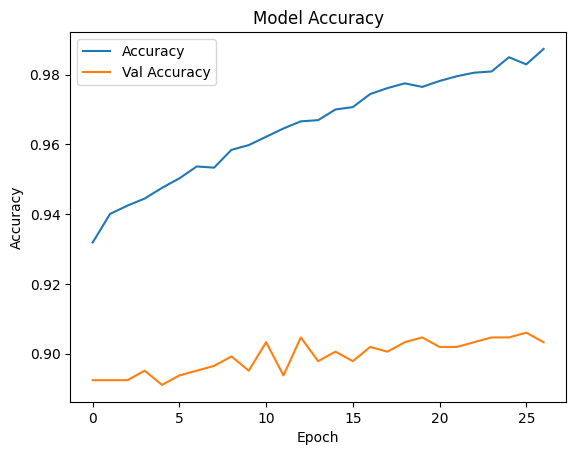

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 5)


In [ ]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[54.785713, 52.785713, 13.785714],
       [54.      , 52.      , 13.      ],
       [54.      , 52.      , 13.      ],
       [54.5     , 52.5     , 13.5     ],
       [55.928574, 53.928574, 14.928572],
       [55.642857, 53.642857, 14.642857],
       [55.      , 53.      , 14.785714],
       [56.214287, 54.214287, 16.214287],
       [57.      , 55.      , 17.      ],
       [57.      , 54.      , 19.      ]], dtype=float32)>

In [ ]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

In [ ]:

from keras.preprocessing import image

In [ ]:
def predict_images_in_directory(model, folder_path, img_width, img_height):
    results = []
    images = []
    filenames = []

    # 디렉토리 내의 모든 이미지 파일 로드
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # 이미지 로드 및 전처리
        img = image.load_img(img_path)
        img = img.numpy().reshape(-1, 224,224,3)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        images.append(img_array)
        filenames.append(filename)

    # 배치 처리를 위해 이미지 스택 생성
    images = np.vstack(images)

    # 예측 수행
    predictions = model.predict(images)

    # 결과 저장
    for filename, pred in zip(filenames, predictions):
        results.append([filename, pred])

    return results

In [ ]:
!ls -al /root/.keras/datasets/flower_photos/flower_photos/

total 616
drwxr-x--- 7 270850 5000   4096 Feb 10  2016 .
drwxr-xr-x 3 root   root   4096 Jun 22 23:59 ..
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips


In [ ]:
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
results = predict_images_in_directory(model, img_path + 'dandelion')
print(results.count(1))
# 결과 출력 (처음 5개만)
for filename, flower_type in results:
    print(f"파일명: {filename}, 꽃종류: {flower_type}")

In [ ]:
import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results, columns=['filename', 'predicted_flower'])

csv_filename = f'flower_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측된 꽃 종류별 개수:")
print(df['predicted_flower'].value_counts())

결과가 flower_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
                      filename predicted_flower
0    3991962484_085ba2da94.jpg        dandelion
1  9293460423_7fbb1e3c32_n.jpg        dandelion
2      61242541_a04395e6bc.jpg        dandelion
3   17574213074_f5416afd84.jpg        dandelion
4  6208857436_14a65fe4af_n.jpg        dandelion

예측된 꽃 종류별 개수:
predicted_flower
dandelion     880
daisy           8
sunflowers      8
tulips          2
Name: count, dtype: int64
